In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
training_exp_name = "training/10_23_23_Dense_WMH"

dfc = rs.load_configs(
    root / training_exp_name,
    properties=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
dfc

,augmentations,data,annotator,axis,in_channels,num_slices,out_channels,preload,slicing,task,...,convs_per_block,filters,optim,lr,weight_decay,train_augmentations,epochs,eval_freq,pretrained_dir,path
0,null,ese.experiment.datasets.WMH,observer_o12,0,1,1,2,False,dense,Amsterdam,...,3,"(64, 64, 64, 64, 64)",torch.optim.Adam,0.0003,0.0,None,1000,10,None,/storage/vbutoi/scratch/ESE/training/10_23_23_...
1,"[{""RandomAffine"": {""degrees"": [0, 360], ""p"": 0...",ese.experiment.datasets.WMH,observer_o12,0,1,1,2,False,dense,Amsterdam,...,3,"(64, 64, 64, 64, 64)",torch.optim.Adam,0.0003,0.0,None,1000,10,None,/storage/vbutoi/scratch/ESE/training/10_23_23_...


In [4]:
%%yaml inference_config

log:
    root: '?'
    log_interval: 50
    track_image_level: True
    track_pixel_level: False 

model:
    exp_root : '?'
    num_workers: 1  

dataset:
    split: '?' 
    slicing: dense_full 
    input_type: volume 

calibration:
    binarize: True
    conf_interval_start: 0.5
    conf_interval_end: 1.0
    num_bins: 10
    neighborhood_width: 3
    square_diff: True

<IPython.core.display.Javascript object>

In [5]:
%%yaml metrics_cfg 

qual_metrics:
    - Accuracy:
        func: ionpy.metrics.segmentation.pixel_accuracy
    - Dice:
        func: ionpy.metrics.segmentation.dice_score
    - IoU:
        func: ionpy.metrics.segmentation.jaccard_score
    - Brier:
        func: ese.experiment.metrics.scoring.brier_score
    - CW_Brier:
        func: ese.experiment.metrics.scoring.cw_brier_score

cal_metrics:
    - ECE:
        func: ese.experiment.metrics.ECE
    - TL_ECE:
        func: ese.experiment.metrics.TL_ECE
    - CW_ECE:
        func: ese.experiment.metrics.CW_ECE
    - LoMS:
        func: ese.experiment.metrics.LoMS
    - TL_LoMS:
        func: ese.experiment.metrics.TL_LoMS
    - CW_LoMS:
        func: ese.experiment.metrics.CW_LoMS

<IPython.core.display.Javascript object>

In [6]:
from ionpy.util import dict_product, Config

# Need to define the experiment name
inference_exp_root = str(root / "inference/12_08_23_WMH_ImageOnly")

# Get the inference options.
##################################################
dataset_options = {
    'log.root': [inference_exp_root],
    'model.exp_root': [str(root / training_exp_name)],
    'dataset.split': ['cal'],
}

base_cfg = Config(inference_config).update(metrics_cfg)

cfgs = []
for cfg_update in dict_product(dataset_options):
    new_cfg = base_cfg.update(cfg_update)
    cfgs.append(new_cfg)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


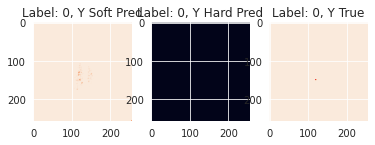

True label amount: 4


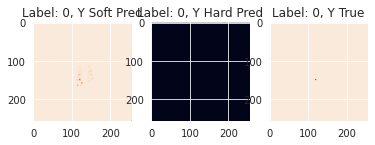

True label amount: 4


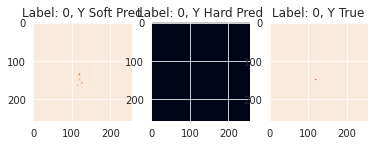

True label amount: 4


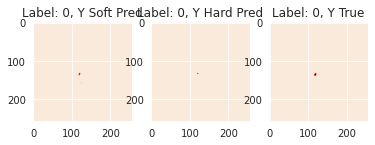

True label amount: 22


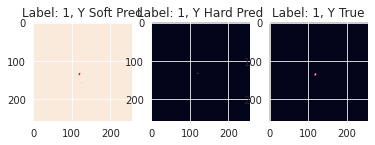

True label amount: 22


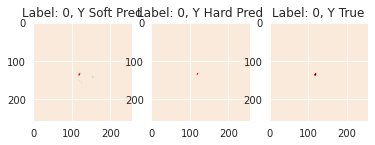

True label amount: 22


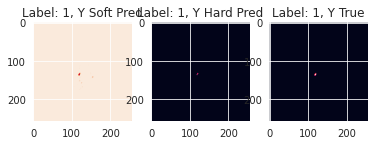

True label amount: 22


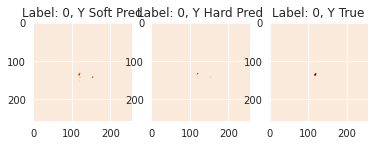

True label amount: 22


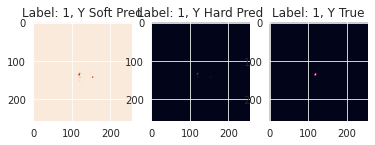

True label amount: 22


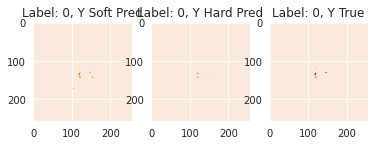

True label amount: 21


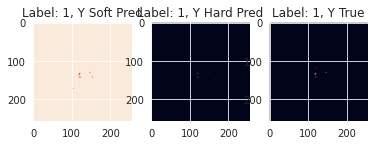

True label amount: 21


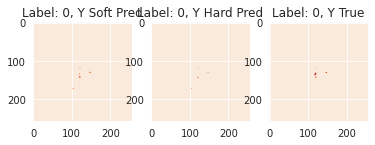

True label amount: 21


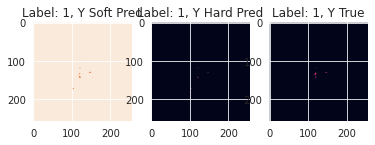

True label amount: 21


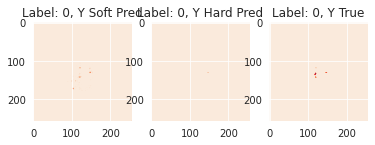

True label amount: 21


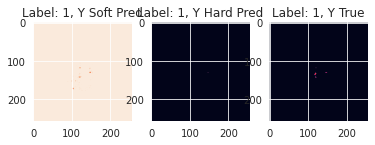

True label amount: 21


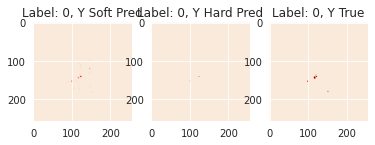

True label amount: 31


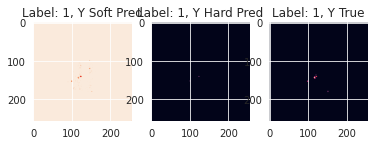

True label amount: 31


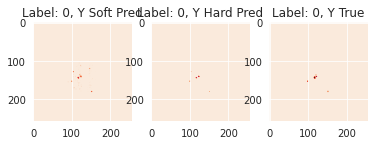

True label amount: 31


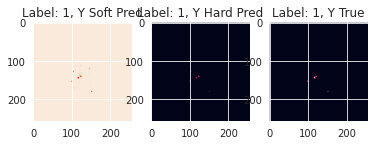

True label amount: 31


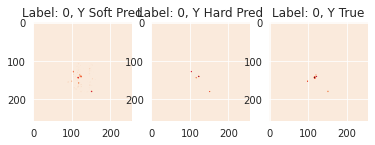

True label amount: 31


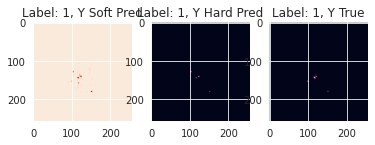

True label amount: 31


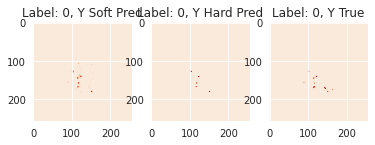

True label amount: 47


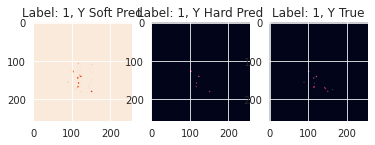

True label amount: 47


KeyboardInterrupt: 

In [7]:
from ese.experiment.analysis.inference import get_cal_stats
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

get_cal_stats(cfgs[0])

In [ ]:
# from ionpy.slite.submit import submit_jobs
# from ese.experiment.analysis.inference import get_cal_stats

# submit_jobs(
#     exp_root=inference_exp_root,
#     config_list=cfgs, 
#     job_func=get_cal_stats,
#     available_gpus=["0"]
#     )